In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from dateutil.relativedelta import relativedelta

today     = datetime.today()
last_year = today - timedelta(days=365)

In [3]:
# compute today and five years ago
today = datetime.today()
ten_years_ago = today - relativedelta(years=10)

ticker = yf.Ticker("^NSEI")
df_raw = ticker.history(
    start=ten_years_ago.strftime("%Y-%m-%d"),
    end=today.strftime("%Y-%m-%d"),
    interval="1d",
    auto_adjust=False,     # keep raw OHLCV
    actions=False          # drop dividends/splits
)

# drop timezone from index
df_raw.index = df_raw.index.tz_localize(None)


In [4]:
ohlcv_df = (
    df_raw
    .loc[:, ["Open", "High", "Low", "Close", "Volume"]]
    .reset_index()
    .rename(columns={"Date": "Date"})
)

ohlcv_df.tail()


,Date,Open,High,Low,Close,Volume
2456,2025-07-04,25428.849609,25470.250000,25331.650391,25461.000000,193500
2457,2025-07-07,25450.449219,25489.800781,25407.250000,25461.300781,196100
2458,2025-07-08,25427.849609,25548.050781,25424.150391,25522.500000,210400
2459,2025-07-09,25514.599609,25548.699219,25424.349609,25476.099609,239100
2460,2025-07-10,25511.650391,25524.050781,25340.449219,25355.250000,219600


In [5]:
df_processed = ohlcv_df.copy()

# Compute raw variance magnitude
raw_var = df_processed['High'] - df_processed['Low']

# Assign sign based on comparison:
# if |High - Close| < |Close - Low| ⇒ positive variance
# else ⇒ negative variance
df_processed['Variance'] = np.where(
    (df_processed['High'] - df_processed['Close']).abs()
    < (df_processed['Close'] - df_processed['Low']).abs(),
    raw_var,
    -raw_var
)

# Use Date as index, formatted dd-mm-yyyy
df_processed['Date'] = df_processed['Date'].dt.strftime('%d-%m-%Y')
df_processed = df_processed.set_index('Date')

# Round all numeric cols to 2 decimals and drop High/Low
df_processed = (
    df_processed
    .drop(columns=['High', 'Low'])
    .round(2)
)

In [6]:
# Z‑score normalization
# Apply (x − μ) / σ to each numeric column in df_processed

df_norm = df_processed.copy()

# Identify numeric columns (all except the index)
numeric_cols = df_norm.columns

# Compute z‑score
df_norm[numeric_cols] = (
    df_norm[numeric_cols]
    .subtract(df_norm[numeric_cols].mean())
    .div(df_norm[numeric_cols].std())
)

# Optional: round to 2 decimal places
df_norm = df_norm.round(4)

# Preview
df_norm


,Open,Close,Volume,Variance
Date,,,,
13-07-2015,-1.1121,-1.0986,-1.1073,0.6069
14-07-2015,-1.0983,-1.0996,-1.1910,0.2896
15-07-2015,-1.0997,-1.0865,-1.1712,0.3545
16-07-2015,-1.0842,-1.0707,-1.1167,0.3796
17-07-2015,-1.0696,-1.0704,-1.1738,-0.2698
...,...,...,...,...
04-07-2025,2.0834,2.0908,-0.7142,0.7249
07-07-2025,2.0874,2.0909,-0.7007,0.4290
08-07-2025,2.0832,2.1024,-0.6264,0.6473


In [7]:
import joblib
from sklearn.preprocessing import StandardScaler

# Assuming you’ve already built df_processed as in your snippet:
# df_processed = ohlcv_df.copy()
# … compute Variance, set Date index, drop High/Low, round …

# Identify the numeric columns you want to scale
numeric_cols = df_processed.columns  # e.g. ['Open','Close','Volume','Variance', ...]

# 1) Instantiate and fit the scaler on your training data
scaler = StandardScaler()
scaler.fit(df_processed[numeric_cols].values)  

# 2) (Optional) transform your data now:
df_scaled = df_processed.copy()
df_scaled[numeric_cols] = scaler.transform(df_processed[numeric_cols].values)

# 3) Save the fitted scaler to disk
joblib.dump(scaler, "scaler.pkl")

print("✅ scaler.pkl created with means:", scaler.mean_, "and scales:", scaler.scale_)

✅ scaler.pkl created with means: [1.43246175e+04 1.43156231e+04 3.31018285e+05 1.30682649e+00] and scales: [5.32884622e+03 5.32953268e+03 1.92510343e+05 1.89355339e+02]


In [33]:
df_norm.shape

(2461, 4)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

In [35]:
# Forecast horizon & sequence length
HORIZON = 7       # predict 7 days ahead
SEQ_LEN = 26     # use past 30 days to predict the next 7
FEATURES = df_norm.shape[1]  # here = 4 (Open, Close, Volume, Variance)

In [36]:
def make_sequences(data: pd.DataFrame, seq_len: int, horizon: int):
    """
    Turn `data` into X, y arrays:
      X.shape = (n_samples, seq_len, n_features)
      y.shape = (n_samples, horizon, n_features_pred)
    Here we predict all features; you can slice to predict only 'Close' if desired.
    """
    arr = data.values
    n = len(arr)
    X, y = [], []
    for i in range(n - seq_len - horizon + 1):
        X.append(arr[i : i + seq_len])
        y.append(arr[i + seq_len : i + seq_len + horizon])
    return np.array(X), np.array(y)

X, y = make_sequences(df_norm, SEQ_LEN, HORIZON)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
print("X_train:", X_train.shape, "y_train:", y_train.shape)


X_train: (1700, 26, 4) y_train: (1700, 7, 4)


In [39]:
model = Sequential([
    # 1st layer: keep full sequences for the next LSTM
    Bidirectional(LSTM(256, return_sequences=True), 
                  input_shape=(SEQ_LEN, FEATURES)),
    Dropout(0.2),
    
    # 2nd layer: ALSO return sequences
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),

    # 3rd layer: ALSO return sequences
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),

    # 4th layer: collapse to a single vector
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),

    # final Dense to map into HORIZON*FEATURES outputs
    Dense(HORIZON * FEATURES, activation='linear'),
])

model.summary()

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ (None, 26, 512)        │       534,528 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 26, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 26, 256)        │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 26, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,398,300 (5.33 MB)

 Trainable params: 1,398,300 (5.33 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train.reshape(len(y_train), HORIZON * FEATURES),
    validation_data=(X_val, y_val.reshape(len(y_val), HORIZON * FEATURES)),
    epochs=500,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Epoch 1/500


54/54 - 48s - 891ms/step - loss: 0.5139 - mae: 0.5028 - val_loss: 0.3555 - val_mae: 0.3508
Epoch 2/500
54/54 - 26s - 475ms/step - loss: 0.3944 - mae: 0.3994 - val_loss: 0.3444 - val_mae: 0.3456
Epoch 3/500
54/54 - 22s - 414ms/step - loss: 0.3803 - mae: 0.3847 - val_loss: 0.3489 - val_mae: 0.3483
Epoch 4/500
54/54 - 22s - 401ms/step - loss: 0.3748 - mae: 0.3806 - val_loss: 0.3380 - val_mae: 0.3282
Epoch 5/500
54/54 - 22s - 402ms/step - loss: 0.3690 - mae: 0.3736 - val_loss: 0.3396 - val_mae: 0.3371
Epoch 6/500
54/54 - 21s - 393ms/step - loss: 0.3646 - mae: 0.3674 - val_loss: 0.3376 - val_mae: 0.3371
Epoch 7/500
54/54 - 22s - 405ms/step - loss: 0.3641 - mae: 0.3671 - val_loss: 0.3336 - val_mae: 0.3173
Epoch 8/500
54/54 - 24s - 438ms/step - loss: 0.3599 - mae: 0.3623 - val_loss: 0.3359 - val_mae: 0.3237
Epoch 9/500
54/54 - 23s - 422ms/step - loss: 0.3583 - mae: 0.3613 - val_loss: 0.3383 - val_mae: 0.3407
Epoch 10/500
54/54 - 22s - 406ms/step - loss: 0.3574 - mae: 0.3605 - val_loss: 0.3324

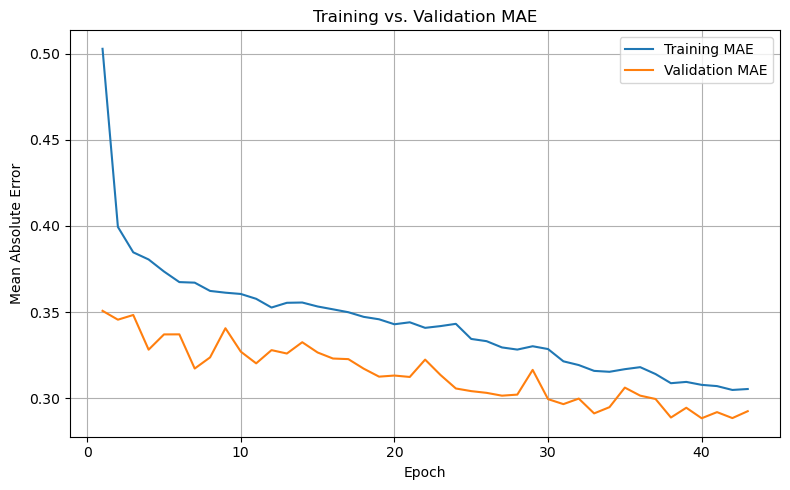

In [41]:
import matplotlib.pyplot as plt

# Extract metrics from history
mae      = history.history['mae']
val_mae  = history.history['val_mae']
epochs   = range(1, len(mae) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, mae,     label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs. Validation MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


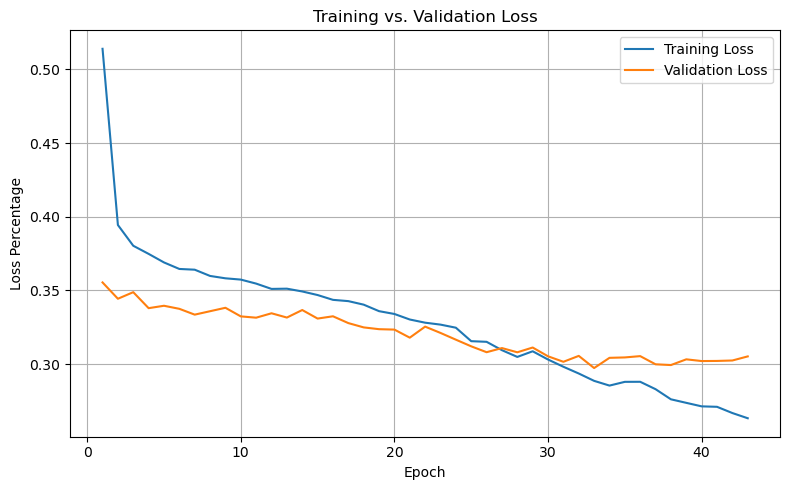

In [42]:
# Extract metrics from history
loss      = history.history['loss']
val_loss  = history.history['val_loss']
epochs   = range(1, len(mae) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss,     label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percentage')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
model.save("bilstm_forcaster.keras")

In [51]:
df_processed.columns

Index(['Open', 'Close', 'Volume', 'Variance'], dtype='object')

In [53]:
# 1) Capture original stats from df_processed
orig_means = df_processed.mean()
orig_stds  = df_processed.std()

# 2) Re-create df_norm
df_norm = df_processed.copy()
numeric_cols = df_norm.columns
df_norm[numeric_cols] = (
    df_norm[numeric_cols]
      .subtract(orig_means)
      .div(orig_stds)
)
df_norm = df_norm.round(4)

# 3) Forecast in normalized space
last_seq = df_norm.values[-SEQ_LEN:].reshape(1, SEQ_LEN, FEATURES)
pred_norm = model.predict(last_seq)                    
pred_norm = pred_norm.reshape(HORIZON, FEATURES)       

df_forecast_norm = pd.DataFrame(pred_norm[:, :3], index=None, columns=['Open', 'Close', 'Volume'])

df_forecast = (
    df_forecast_norm.mul(orig_stds, axis=1)
                    .add(orig_means, axis=1)
                    [['Open', 'Close', 'Volume']]
                    .round(2)
)

# 6) Round and print
df_forecast = df_forecast.round(2)
print(df_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
       Open     Close     Volume
0  25085.73  24962.29  252636.96
1  25072.57  24989.76  274392.21
2  24841.07  24838.03  247550.93
3  24808.34  24809.26  229374.50
4  24793.44  24891.35  255285.02
5  24870.20  24751.63  229246.97
6  24917.14  24973.95  247421.24


In [1]:
import tensorflow as tf